In [209]:
import scipy.io
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patches as patches
from matplotlib.path import Path
import operator 

# Image I/O
import skimage.io
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
import scipy.misc
import Image, ImageOps

# Image Filtering
import scipy.ndimage.filters
import scipy.stats as st
import scipy.signal
import scipy.ndimage

%matplotlib inline

# Utilities

In [2]:
# Display Images
def plot_1x2(img1, img2):
    fig = plt.figure(figsize = (20,10))
    ax1, ax2 = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)
    ax1.imshow(img1, cmap='gray')
    ax2.imshow(img2, cmap='gray')

In [3]:
# Convert RGB images to Grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [77]:
# Extract patch around given coordinate
def extract_patch(pt, img):
    patch = []
    x_slide = [-1,0,1]
    y_slide = [-1,0,1]
    img_x = int(pt[0])
    img_y = int(pt[1])
    
    # Assuming bounds are already validated
    for x in x_slide:
        tmp = []
        for y in y_slide:
            tmp.append(img[img_x+x, img_y+y])
        patch.append(tmp)
    return patch

In [196]:
# Plot corners on imgage
def plot_corner(img, corners):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    count = 0
    for elem in corners:
        circ = Circle((elem[1], elem[0]),10)
        ax.add_patch(circ)
        count += 1
        if count > 100:
            break
    plt.show()

In [187]:
# Concatenate images and draw lines between correct matches
def draw_lines(img1, img2, correct_matches):
    offset = img1.shape[1]
    stack_img = np.hstack((img1, img2))
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.imshow(stack_img, cmap='gray')
    codes = [Path.MOVETO,Path.LINETO]
    
    for match in correct_matches:
        verts = [(match[0][1], match[0][0]), (match[1][1]+offset, match[1][0])]
        path = Path(verts, codes)
        ax.add_patch(patches.PathPatch(path, color='green', lw=2.0))
    plt.show()

In [241]:
def plot_correspondence(img1, img2, cor1, cor2):
    
    offset = img1.shape[0] - img2.shape[0]
    img_shift = img1.shape[1]
    top1 = 0
    top2 = 0
    if offset > 0:
        top2 = offset
    elif offset < 0:
        top1 = abs(offset)
    
    new_img1 = cv2.copyMakeBorder(img1,top1,0,0,0,1,0)
    new_img2 = cv2.copyMakeBorder(img2,top2,0,0,0,1,0)
    
    stack_img = np.hstack((new_img1, new_img2))

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.imshow(stack_img, cmap='gray')
    codes = [Path.MOVETO,Path.LINETO]

    for elem in cor1:
        circ = Circle((elem[0], elem[1]+top1),10)
        ax.add_patch(circ)

    for elem in cor2:
        circ = Circle((elem[0]+img_shift, elem[1]+top2),10)
        ax.add_patch(circ)
    
    codes = [Path.MOVETO,Path.LINETO]
    for elem1, elem2 in zip(cor1, cor2):
        verts = [(elem1[0], elem1[1]+top1), (elem2[0]+img_shift, elem2[1]+top2)]
        path = Path(verts, codes)
        ax.add_patch(patches.PathPatch(path, color='green', lw=2.0))
    plt.show()

# Load Data

In [4]:
dino_mat = scipy.io.loadmat('data/dino2.mat')
dino_01 = np.array(dino_mat['dino01'])
dino_02 = np.array(dino_mat['dino02'])
cor_01 = np.array(dino_mat['cor1'])
cor_02 = np.array(dino_mat['cor2'])

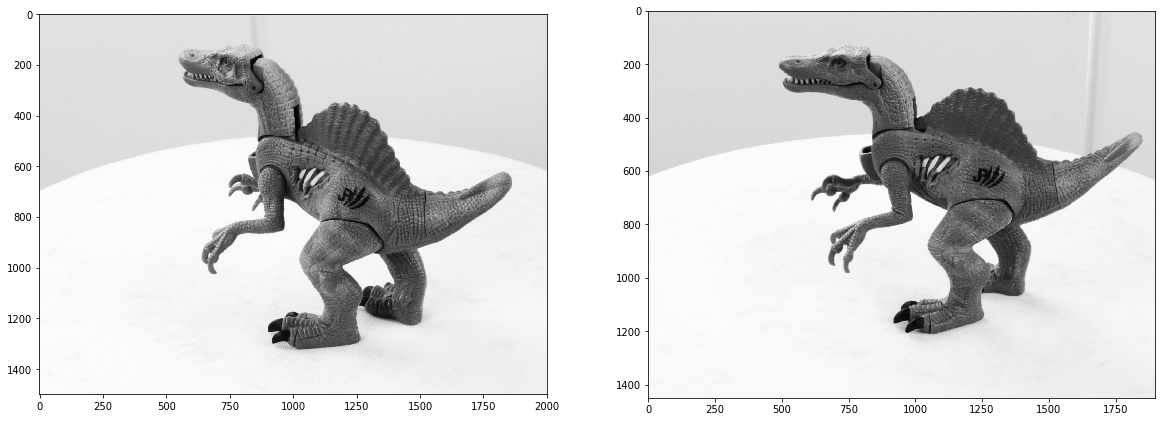

In [5]:
dino_01 = rgb2gray(dino_01)
dino_02 = rgb2gray(dino_02)
plot_1x2(dino_01, dino_02)

# Gaussian Filtering

In [6]:
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

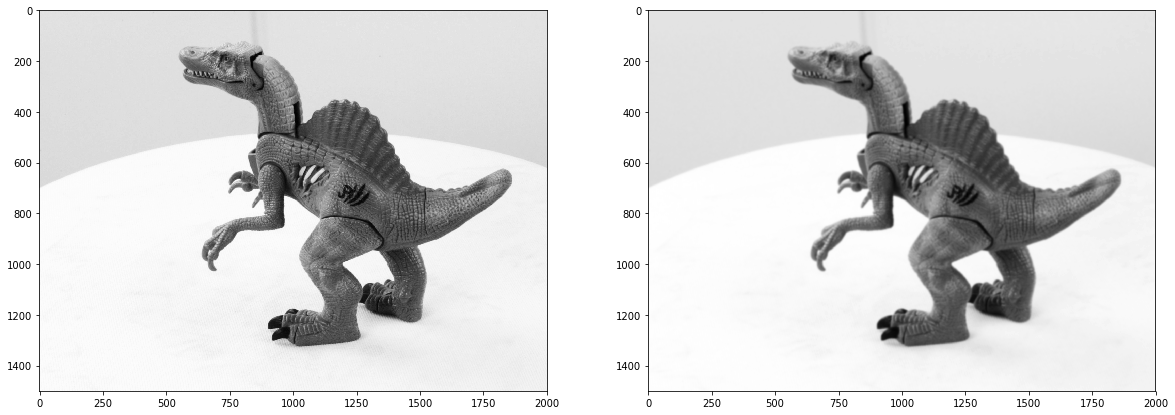

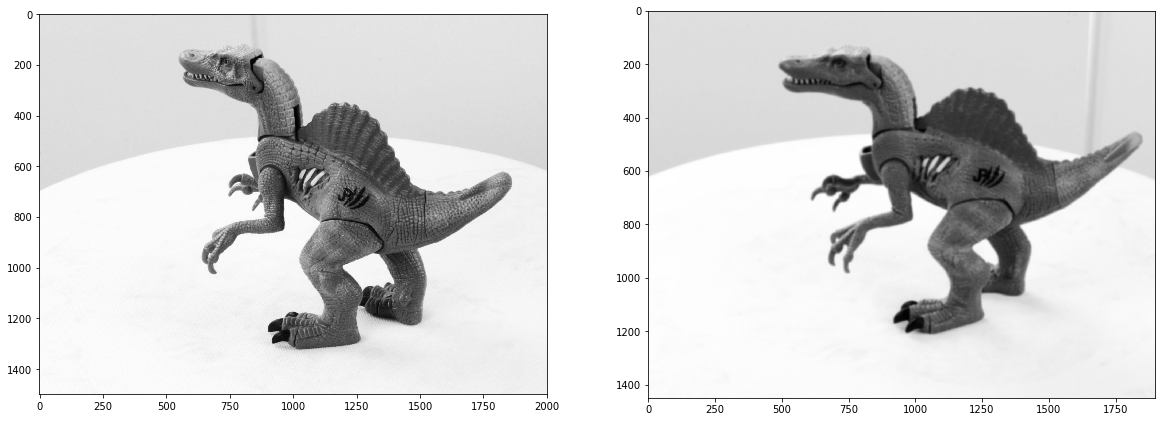

In [71]:
smooth_dino_01 = scipy.ndimage.filters.correlate(dino_01, gkern(21,5))
smooth_dino_02 = scipy.ndimage.filters.correlate(dino_02, gkern(21,5))
plot_1x2(dino_01, smooth_dino_01)
plot_1x2(dino_01, smooth_dino_02)

# Image Gradients

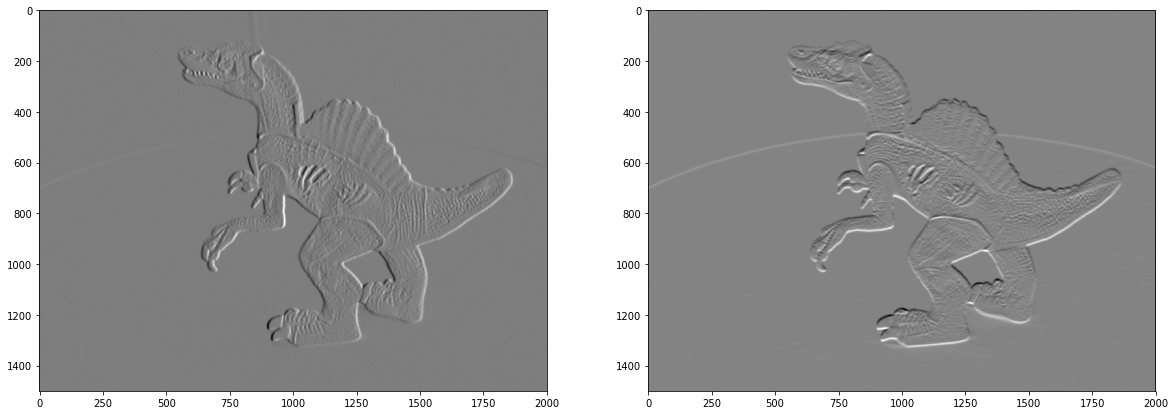

In [72]:
gradient_x = [[-1,0,1],[-1,0,1],[-1,0,1]] # gradient along x
graident_y = [[-1,-1,-1],[0,0,0],[1,1,1]] # gradient along y

I_x = scipy.ndimage.filters.correlate(smooth_dino_01, gradient_x)
I_y = scipy.ndimage.filters.correlate(smooth_dino_01, graident_y)
plot_1x2(I_x, I_y)

# Corner Detection

In [31]:
# Compute elements of C Matrix
I_x2 = np.multiply(I_x, I_x)
I_y2 = np.multiply(I_y, I_y)
I_xy = np.multiply(I_x, I_y)

In [32]:
row, col = dino_01.shape
C_min = np.zeros((row,col))
C_max = np.zeros((row,col))

# Store minimum eigen values in  separate matrix 
for i in range(row):
    for j in range(col):
            C_min[i,j] = min(np.linalg.eigvals([[I_y2[i,j], I_xy[i,j]], [I_xy[i,j], I_x2[i,j]]]))
            C_max[i,j] = max(np.linalg.eigvals([[I_y2[i,j], I_xy[i,j]], [I_xy[i,j], I_x2[i,j]]]))

In [39]:
x_slide = [-1,0,1]
y_slide = [-1,0,1]
corners = []

# Validate element to be evaluated
def isvalid(new_x, new_y, x, y, max_x, max_y):
    if new_x < 0 or new_x >= max_x:
        return False
    elif new_y < 0 or new_y >= max_y:
        return False
    elif new_x == x and new_y == y:
        return False
    else:
        return True
    
# For each pixel, choose the coordinate points of those that have 
# largest min eigen value among neighbors   
for i in range(row):
    for j in range(col):
        flag = True
        for x in x_slide:
            for y in y_slide:
                if isvalid(i+x, j+y, i, j, row, col):
                    if C_min[i,j] < C_min[i+x,j+y]:
                        flag = False
        if flag == True:
            corners.append((i,j,C_min[i,j]))                

In [41]:
# Sort detected corners based on corner score
corners.sort(key=operator.itemgetter(2), reverse=True)

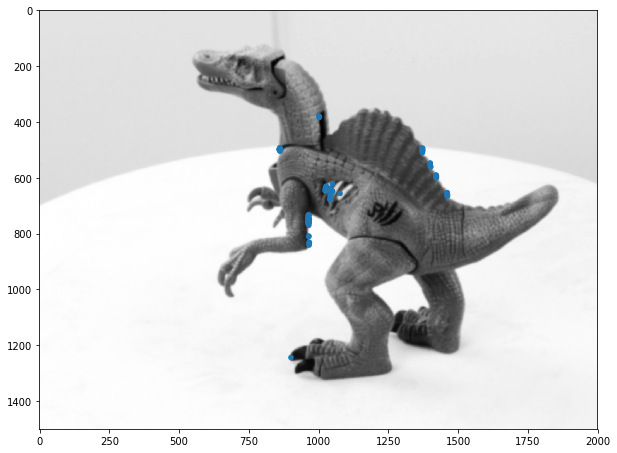

In [73]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(smooth_dino_01, cmap='gray')
count = 0

for elem in corners:
    circ = Circle((elem[1], elem[0]),10)
    ax.add_patch(circ)
    count += 1
    if count > 100:
        break
plt.show()

In [126]:
# Detect corners for dino_02 
def corner_detect(img, num_corners):
    # Smoothen Image
    smooth_dino = scipy.ndimage.filters.correlate(img, gkern(21,5))
    
    # Compute Gradients
    gradient_x = [[-1,0,1],[-1,0,1],[-1,0,1]] # gradient along x
    graident_y = [[-1,-1,-1],[0,0,0],[1,1,1]] # gradient along y

    I_x = scipy.ndimage.filters.correlate(smooth_dino, gradient_x)
    I_y = scipy.ndimage.filters.correlate(smooth_dino, graident_y)
    
    # Compute elements of C Matrix
    I_x2 = np.multiply(I_x, I_x)
    I_y2 = np.multiply(I_y, I_y)
    I_xy = np.multiply(I_x, I_y)

    row, col = img.shape
    C_min = np.zeros((row,col))
    C_max = np.zeros((row,col))

    # Store minimum eigen values in  separate matrix 
    for i in range(row):
        for j in range(col):
                C_min[i,j] = min(np.linalg.eigvals([[I_y2[i,j], I_xy[i,j]], [I_xy[i,j], I_x2[i,j]]]))
                C_max[i,j] = max(np.linalg.eigvals([[I_y2[i,j], I_xy[i,j]], [I_xy[i,j], I_x2[i,j]]])) 
                
    x_slide = [-1,0,1]
    y_slide = [-1,0,1]
    corners = []

    # For each pixel, choose the coordinate points of those that have 
    # largest min eigen value among neighbors   
    for i in range(row):
        for j in range(col):
            flag = True
            for x in x_slide:
                for y in y_slide:
                    if isvalid(i+x, j+y, i, j, row, col):
                        if C_min[i,j] < C_min[i+x,j+y]:
                            flag = False
            if flag == True:
                corners.append((i,j,C_min[i,j]))
                
    # Sort detected corners based on corner score
    corners.sort(key=operator.itemgetter(2), reverse=True)
    return corners[:num_corners]

In [45]:
dino_02_corners = corner_detect(dino_02, 100)

# Stereo Correspondence Matching

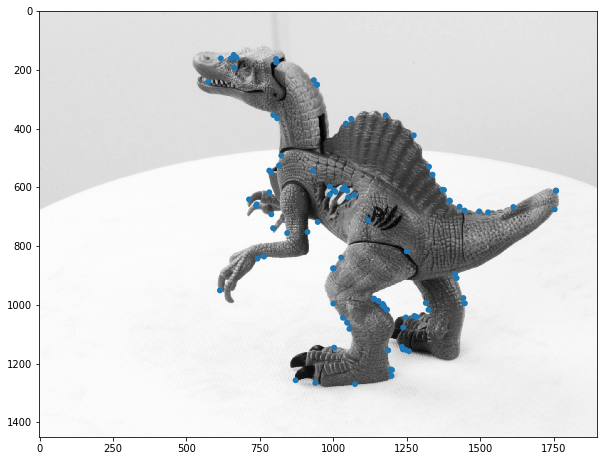

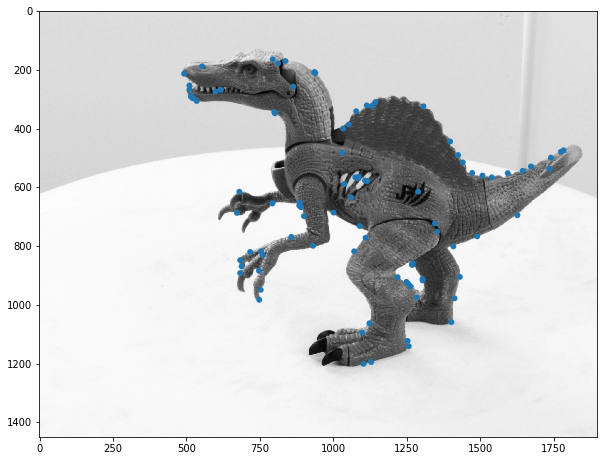

In [128]:
# Resize images to smallest possible dimension before processing 
dino_01 = scipy.misc.imresize(dino_01,(1450,1900))
dino_02 = scipy.misc.imresize(dino_02,(1450,1900))

# Number of corners to detect
num_corners = 100

# Find corners on both images 
dino_01_corners = corner_detect(dino_01, num_corners)
dino_02_corners = corner_detect(dino_02, num_corners)

# Plot corners on Images 
plot_corner(dino_01, dino_01_corners)
plot_corner(dino_02, dino_02_corners)

In [135]:
# Compute NSSD
def nssd(corner1, corner2, img1, img2, thresh=0.001):
    
    # Check for corners in boundaries
    if (corner1[0] == 0) or (corner1[1] == 0) or \
        (corner1[0] == img1.shape[0]-1) or (corner1[1] == img1.shape[1]-1):
            return Inf
    if (corner2[0] == 0) or (corner2[1] == 0) or \
        (corner2[0] == img2.shape[0]-1) or (corner2[1] == img2.shape[1]-1):
            return Inf
        
    # Extract patch around corner and normalize
    cor1_mat = extract_patch(corner1, img1)
    cor2_mat = extract_patch(corner2, img2)
    norm_cor1 = normalize(cor1_mat)
    norm_cor2 = normalize(cor2_mat)
    
    # Return sum of squared differences 
    return sum(sum(np.subtract(norm_cor1,norm_cor2)**2))

In [166]:
# Check for closest matching corners
def find_matches(corners_01, corners_02, img1, img2, thresh=0.0001):
    correct_matches = []
    for cor1 in corners_01:
        min_dist = thresh #very large value
        match_point = (-1,-1)
        for cor2 in corners_02:
            pt_dist = nssd(cor1, cor2, img1, img2, thresh)
            if pt_dist < min_dist:
                min_dist = pt_dist
                match_point = cor2
        if match_point != (-1,-1):
            correct_matches.append((cor1,match_point))
    return correct_matches

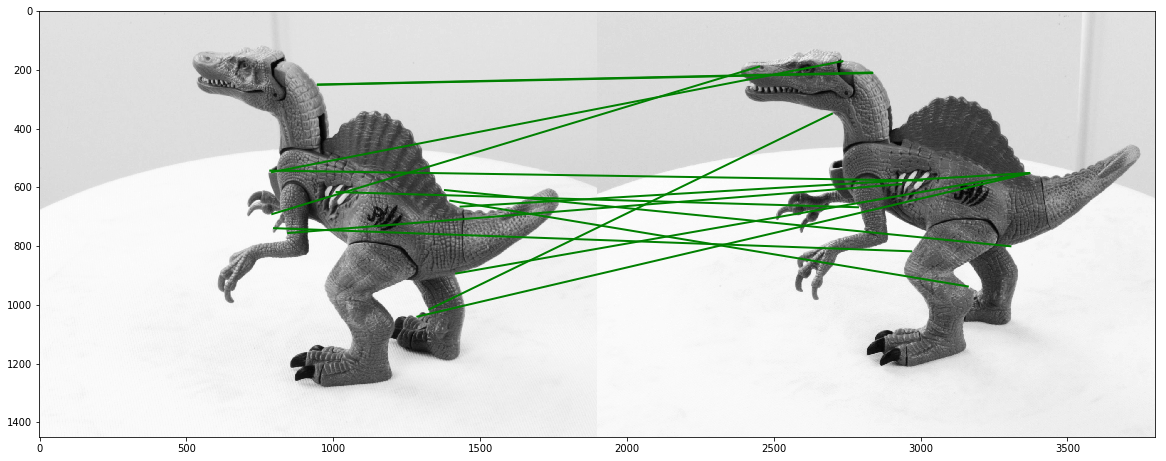

Found 14 closest corner matches


In [191]:
# Find closest corner matches
thresh = 0.0002
correct_matches = find_matches(dino_01_corners, dino_02_corners, dino_01, dino_02, thresh)
draw_lines(dino_01, dino_02, correct_matches)
print "Found %d closest corner matches"% len(correct_matches)

# Fundamental Matrix Estimation

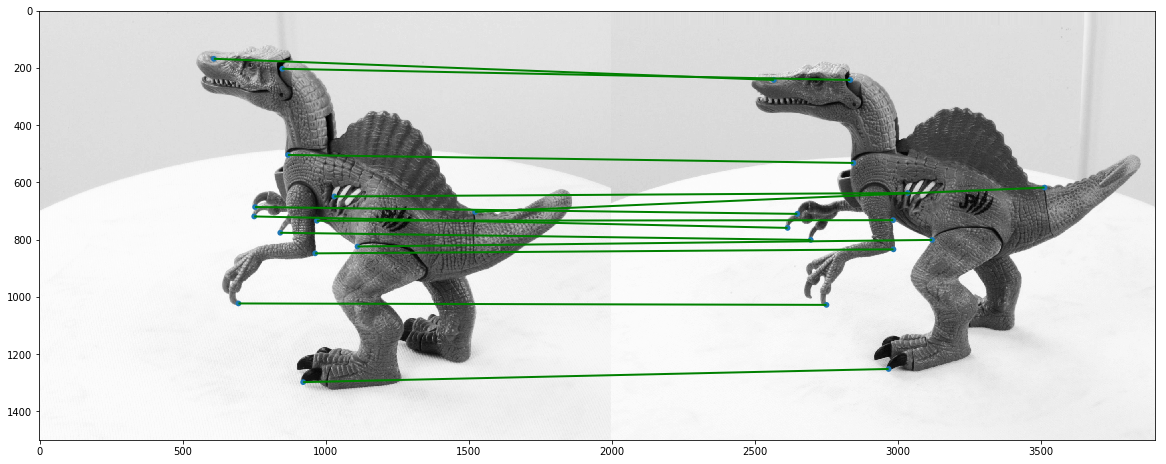

In [243]:
# Plot correspondence for matching corners
orig_dino_01 = rgb2gray(np.array(dino_mat['dino01']))
orig_dino_02 = rgb2gray(np.array(dino_mat['dino02']))
cor_01 = np.array(dino_mat['cor1'])
cor_02 = np.array(dino_mat['cor2'])
plot_correspondence(orig_dino_01, orig_dino_02, cor_01, cor_02)

In [313]:
def estimate_fundamental_matrix(cor1, cor2):
    # TODO: Elaborate DLT algorithm
    F, mask = cv2.findFundamentalMat(np.float32(cor1), np.float32(cor2), cv2.FM_8POINT)
    return F

In [321]:
# Compute fundamental matrix using corresponding points 
F = estimate_fundamental_matrix(cor_01, cor_02)

epipolar_lines = []
# Estimate epipolar line for each corner point. 
for cor in cor_01:
    x = np.hstack((cor,[1]))
    l = np.dot(F,x)
    epipolar_lines.append([l[0], l[1], l[2]])

# TODO: Plot Epipolar Line on image. 

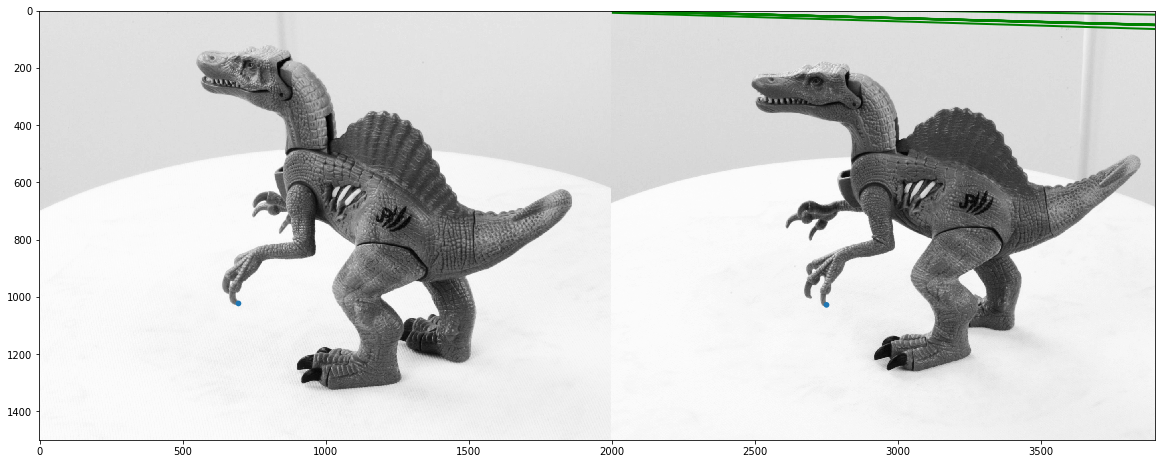

In [333]:
# FAILED EXPERIMENT :  PLEASE HELP!! 

# Prepare image for plotting  
img1 = orig_dino_01
img2 = orig_dino_02

offset = img1.shape[0] - img2.shape[0]
img_shift = img1.shape[1]
top1 = 0
top2 = 0
if offset > 0:
    top2 = offset
elif offset < 0:
    top1 = abs(offset)
    
# Pad image to maintain same dimensions
new_img1 = cv2.copyMakeBorder(img1,top1,0,0,0,1,0)
new_img2 = cv2.copyMakeBorder(img2,top2,0,0,0,1,0)
stack_img = np.hstack((new_img1, new_img2))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.imshow(stack_img, cmap='gray')
codes = [Path.MOVETO,Path.LINETO]

# Plot all corners in stacked image
for elem in cor_01:
    circ = Circle((elem[0], elem[1]+top1),10)
    ax.add_patch(circ)   
    break

for elem in cor_02:
    circ = Circle((elem[0]+img_shift, elem[1]+top2),10)
    ax.add_patch(circ)
    break

# TODO: Compute line equation and plot on the image
# ISSUE : Estimated epipolar line not passing through corresponding point. Nowhere close to it !

codes = [Path.MOVETO,Path.LINETO]
for line in epipolar_lines:
    # Convert line to inhomogenous plane
    # TODO: Check if this is correct
    slope = line[0]/line[2]
    intercept = line[1]/line[2]
    
    # Looks like I am plotting the lines incorrectly
    verts = [(img_shift, slope*img_shift+intercept+top1), 
             (img2.shape[1]+img_shift, slope*(img2.shape[1]+img_shift)+intercept+top2)]
    path = Path(verts, codes)
    ax.add_patch(patches.PathPatch(path, color='green', lw=2.0))

plt.show()